## 0. Configurations

In [1]:
# ====================================================================
# STEP 0: Import Libraries
# ====================================================================

In [ ]:
# 시스템 및 입출력 관련
import os  # 디렉토리, 파일 경로 조작 등
from PIL import Image  # 이미지 열기 및 처리 (Pillow)
from tqdm import tqdm  # 반복문의 진행 상태 시각화
from pathlib import Path  # payhon path
import shutil # 파일 복사/이동
import torch

# 시각화 도구
import matplotlib.pyplot as plt  # 기본 시각화
import matplotlib
# 한글 폰트 설정 (Windows의 기본 한글 폰트)
matplotlib.rc('font', family='Malgun Gothic')
# 마이너스 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False
import matplotlib.patches as patches

# 주피터 노트북에서 이미지 인라인 표시를 위한 매직 명령어 추가 (여기 추가)
%matplotlib inline

# 이미지 처리
import cv2  # OpenCV - 고급 이미지/비디오 처리

# 수치 연산
import numpy as np  # 배열, 벡터 계산 등

# 통계 tool
import pandas as pd
from collections import defaultdict, Counter

# 싸이킷런 데이터 나누기
from sklearn.model_selection import train_test_split

# 랜덤성 추가
import random

# JSON
import json

# YOLOv8 라이브러리
from ultralytics import YOLO

# yaml 라이브러리
import yaml 

# --- 디바이스 설정 ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

# --- 학습 하이퍼파라미터 ---
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

import config

In [3]:
# 재현성을 위해 모든 난수 생성기의 시드를 고정하는 함수.
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

In [4]:
# 디바이스 확인
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
# ====================================================================
# STEP 1: Define Paths
# ====================================================================
PROJECT_ROOT = Path("/Users/user/myproject/AI03-Project-1")
DATA_ROOT = Path(
    "/Users/user/myproject/AI03-Project-1/data/raw"
)  # 실제 데이터 경로로 변경 필요
train_image_dir = DATA_ROOT / "train_images"
train_ann_path = DATA_ROOT / "train_annotations"
test_image_dir = DATA_ROOT / "test_images"

In [6]:
# YOLOv8 데이터를 저장할 새 디렉토리
YOLO_DATA_ROOT = (
    Path("/Users/user/myproject/AI03-Project-1/data") / "processed" / "yolov8_dataset"
)
YOLO_IMAGES_TRAIN = YOLO_DATA_ROOT / "images" / "train"
YOLO_LABELS_TRAIN = YOLO_DATA_ROOT / "labels" / "train"
YOLO_IMAGES_VAL = YOLO_DATA_ROOT / "images" / "val"
YOLO_LABELS_VAL = YOLO_DATA_ROOT / "labels" / "val"
YOLO_LABELS_TEMP = (
    Path("/Users/user/myproject/AI03-Project-1/data") / "processed" / "yolo_labels_temp"
)  # 변환된 .txt 파일을 임시로 저장할 곳

In [7]:
# 디렉토리 생성
os.makedirs(YOLO_IMAGES_TRAIN, exist_ok=True)
os.makedirs(YOLO_LABELS_TRAIN, exist_ok=True)
os.makedirs(YOLO_IMAGES_VAL, exist_ok=True)
os.makedirs(YOLO_LABELS_VAL, exist_ok=True)
os.makedirs(YOLO_LABELS_TEMP, exist_ok=True)

In [8]:
# 시드 고정
seed_everything(SEED)

Seed set to 42


## 1. Data-preprocessing

In [9]:
# ====================================================================
# STEP 2: Parse Annotations and Convert to YOLO Format
# ====================================================================


def create_yolo_annotations_and_map(
    annotation_root: Path, train_image_dir: Path, yolo_labels_output_dir: Path
):
    """
    제공된 복잡한 JSON 어노테이션 폴더 구조를 파싱하고 YOLO 형식(.txt)으로 변환하여 저장합니다.
    - train_images: 이미지 파일들 (예: K-XXXXX_Y_Z.png)
    - train_annotations:
        - K-XXXXX_Y_Z_json/ (이미지 그룹 폴더)
            - K-AAAAA/ (개별 약제 ID 폴더)
                - K-XXXXX_Y_Z.json (해당 이미지 내 K-AAAAA 약제의 어노테이션)

    각 이미지에 대한 어노테이션이 여러 JSON 파일(각 알약별)에 분산되어 있으므로
    JSON 파일명이 원본 이미지 파일명과 동일한 형태를 처리합니다.
    """

    category_id_to_name = {}

    # 1. 모든 JSON 파일을 스캔하여 category_id_to_name 맵 수집
    # 모든 JSON 파일에서 클래스 정보를 한 번에 수집합니다.
    all_json_paths_for_categories_scan = []
    for dirpath, _, filenames in os.walk(annotation_root):
        for fname in filenames:
            if fname.endswith(".json"):
                all_json_paths_for_categories_scan.append(os.path.join(dirpath, fname))

    print(
        f"Scanning {len(all_json_paths_for_categories_scan)} JSON files to collect categories..."
    )

    for json_path in tqdm(
        all_json_paths_for_categories_scan, desc="Collecting categories"
    ):
        try:
            with open(json_path, "r", encoding="utf-8") as f:
                data = json.load(f)
                if "categories" in data:
                    for cat in data["categories"]:
                        category_id_to_name[cat["id"]] = cat["name"]
        except (json.JSONDecodeError, KeyError) as e:
            print(
                f"Warning: Could not parse categories from {json_path} due to {e}. Skipping."
            )
            continue

    sorted_category_ids = sorted(list(category_id_to_name.keys()))
    yolo_class_id_map = {cat_id: idx for idx, cat_id in enumerate(sorted_category_ids)}
    yolo_idx_to_name_map = {
        idx: category_id_to_name[cat_id] for cat_id, idx in yolo_class_id_map.items()
    }

    print(f"\nDetected {len(sorted_category_ids)} unique categories.")

    for cat_id in sorted_category_ids:
        print(
            f"  Original ID: {cat_id}, YOLO ID: {yolo_class_id_map[cat_id]}, Name: {category_id_to_name[cat_id]}"
        )

    # 2. train_images 폴더의 모든 이미지 파일 목록을 확보
    all_image_files_in_dir = []
    # 이미지 확장자들을 유연하게 처리
    for ext in [".png", ".jpg", ".jpeg", ".PNG", ".JPG", ".JPEG"]:
        all_image_files_in_dir.extend(list(train_image_dir.glob(f"*{ext}")))
    all_image_files_in_dir = sorted(
        list(set(all_image_files_in_dir))
    )  # 중복 제거 및 정렬

    print(f"\nFound {len(all_image_files_in_dir)} image files in {train_image_dir}")

    # YOLO 라벨을 저장할 임시 디렉토리 생성
    yolo_labels_output_dir.mkdir(parents=True, exist_ok=True)

    annotations_info = defaultdict(dict)  # 각 이미지에 대한 정보를 저장

    # 3. 각 이미지 파일에 대해 해당 이미지의 모든 알약 JSON 어노테이션을 찾아 YOLO 형식으로 변환
    processed_json_count = 0
    generated_yolo_labels_count = 0

    for img_path in tqdm(
        all_image_files_in_dir, desc="Processing images and consolidating annotations"
    ):
        img_stem = (
            img_path.stem
        )  # 예: 'K-001900-010224-016551-031705_0_2_0_2_70_000_200'

        try:
            with Image.open(img_path) as img:
                img_w, img_h = img.size
        except Exception as e:
            print(f"Error opening image {img_path}: {e}. Skipping this image.")
            continue

        yolo_lines_for_this_image = []
        found_ann_for_current_image = (
            False  # 현재 이미지에 대해 유효한 어노테이션을 찾았는지 여부
        )

        # annotation_root 아래의 모든 JSON 파일을 재귀적으로 탐색
        # JSON 파일명이 현재 이미지의 stem과 정확히 일치하는 파일을 찾음
        for dirpath, _, filenames in os.walk(annotation_root):
            for fname in filenames:
                # JSON 파일명이 현재 이미지 파일명(확장자 제외)과 일치하는지 확인
                if fname.endswith(".json") and Path(fname).stem == img_stem:
                    json_file_path = Path(dirpath) / fname

                    try:
                        with open(json_file_path, "r", encoding="utf-8") as f:
                            ann_data = json.load(f)
                        processed_json_count += 1

                        # JSON 내의 bbox, category_id 추출
                        # 각 JSON 파일은 단 하나의 'annotation' 객체를 포함하거나, 'annotations' 리스트가 있다면 그 리스트의 첫 번째 항목만 유효한 것으로 간주
                        # JSON 구조는 {"annotations": [{"bbox": [...], "category_id": ...}], ...}

                        if (
                            "annotations" in ann_data and ann_data["annotations"]
                        ):  # 어노테이션이 실제로 있는지를 먼저 확인하는 조건
                            for ann in ann_data[
                                "annotations"
                            ]:  # 여러 바운딩 박스가 있을 수도 있으니 반복
                                if (
                                    "bbox" in ann and "category_id" in ann
                                ):  # bbox와 category_id 모두 존재하는 경우에 처리
                                    x, y, w, h = ann[
                                        "bbox"
                                    ]  # COCO format: [x_min, y_min, width, height]
                                    original_category_id = ann["category_id"]

                                    # 바운딩 박스 유효성 검사 및 클리핑 (이미지 경계를 벗어나지 않도록)
                                    x1 = max(0, int(x))  # 음수 방지
                                    y1 = max(0, int(y))  # 음수 방지
                                    x2 = min(
                                        int(x + w), img_w
                                    )  # 우하단 x좌표 (이미지 폭 초과 방지)
                                    y2 = min(
                                        int(y + h), img_h
                                    )  # 우하단 y좌표 (이미지 높이 초과 방지)

                                    if (
                                        x2 <= x1 or y2 <= y1
                                    ):  # 유효하지 않은 바운딩 박스는 건너뜀
                                        print(
                                            f"Warning: Invalid bbox {ann['bbox']} in {json_file_path}. Skipping."
                                        )
                                        continue

                                    # YOLO 형식으로 변환: [center_x, center_y, width, height] 정규화
                                    norm_center_x = ((x1 + x2) / 2) / img_w
                                    norm_center_y = ((y1 + y2) / 2) / img_h
                                    norm_width = (x2 - x1) / img_w
                                    norm_height = (y2 - y1) / img_h

                                    # 클래스 ID 매핑
                                    if original_category_id in yolo_class_id_map:
                                        yolo_class_id = yolo_class_id_map[
                                            original_category_id
                                        ]
                                        yolo_lines_for_this_image.append(
                                            f"{yolo_class_id} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}"  # .6f는 YOLO 형식에서 권장되는 정도의 정밀도
                                        )
                                        found_ann_for_current_image = True  # 해당 이미지의 라벨 txt 파일 저장 여부를 판단하는 데 사용
                                    else:
                                        print(
                                            f"Warning: Original category ID {original_category_id} not found in collected categories for {json_file_path}. Skipping this annotation."
                                        )  # 매핑이 안 되어 있는 클래스 ID가 있을 경우, 그 바운딩 박스는 건너뜀
                                else:
                                    print(
                                        f"Warning: Annotation in {json_file_path} missing 'bbox' or 'category_id'. Skipping."
                                    )  # 어노테이션(ann) 안에 'bbox' 또는 'category_id' 키가 없으면 건너뜀.

                    except (
                        json.JSONDecodeError
                    ) as e:  # JSON 형식 자체가 잘못되었을 때 발생
                        print(f"Error decoding JSON {json_file_path}: {e}. Skipping.")
                    except (
                        KeyError
                    ) as e:  # 'annotations'나 'images' 키가 누락된 JSON 구조일 때 발생
                        print(
                            f"KeyError in JSON {json_file_path}: {e}. Skipping. (Missing expected keys in annotation structure?)"
                        )
                    except (
                        Exception
                    ) as e:  # 위의 예외들 외에 발생할 수 있는 모든 예외에 대한 포괄적인 처리(타입 변환 실패, 리스트 인덱스 오류)
                        print(
                            f"Unexpected error processing JSON {json_file_path}: {e}. Skipping."
                        )

        # 모든 관련 JSON을 처리한 후, 현재 이미지에 대한 YOLO 어노테이션 파일 저장
        output_txt_filename = img_stem + ".txt"  # .txt 파일 생성
        output_txt_path = yolo_labels_output_dir / output_txt_filename  # 경로 지정

        if (
            found_ann_for_current_image
        ):  # 하나 이상의 유효한 어노테이션을 찾은 경우만 .txt를 저장, 의미 없는 빈 .txt 파일 생성을 방지
            with open(
                output_txt_path, "w", encoding="utf-8"
            ) as f:  # output_txt_path 경로에 .txt 파일을 쓰기 모드('w')로 열고,
                f.write(
                    "\n".join(yolo_lines_for_this_image)
                )  # yolo_lines_for_this_image 리스트(각 줄은 "class_id cx cy w h" 형식)를 줄바꿈으로 이어서 저장.

            # annotations_info에는 성공적으로 라벨링된 이미지 정보만 저장
            annotations_info[img_path.name] = {
                "yolo_label_path": output_txt_path,
                "image_path": img_path,
            }
            generated_yolo_labels_count += 1
        else:
            # 이 이미지를 위한 유효한 어노테이션이 하나도 발견되지 않은 경우
            print(
                f"Warning: No valid annotations found for image {img_path.name}. Skipping label creation for this image."
            )

    print(f"\n--- Annotation Processing Summary ---")
    print(f"Total JSON files processed: {processed_json_count}")
    print(f"Total YOLO label files generated: {generated_yolo_labels_count}")
    print(f"YOLO format annotations saved to: {yolo_labels_output_dir}")
    return annotations_info, yolo_class_id_map, yolo_idx_to_name_map

In [10]:
# yolo 어노테이션 파일 생성 실행
annotations_info, yolo_class_id_map, yolo_idx_to_name_map = (
    create_yolo_annotations_and_map(train_ann_path, train_image_dir, YOLO_LABELS_TEMP)
)

Scanning 4526 JSON files to collect categories...



Detected 73 unique categories.
  Original ID: 1899, YOLO ID: 0, Name: 보령부스파정 5mg
  Original ID: 2482, YOLO ID: 1, Name: 뮤테란캡슐 100mg
  Original ID: 3350, YOLO ID: 2, Name: 일양하이트린정 2mg
  Original ID: 3482, YOLO ID: 3, Name: 기넥신에프정(은행엽엑스)(수출용)
  Original ID: 3543, YOLO ID: 4, Name: 무코스타정(레바미피드)(비매품)
  Original ID: 3742, YOLO ID: 5, Name: 알드린정
  Original ID: 3831, YOLO ID: 6, Name: 뉴로메드정(옥시라세탐)
  Original ID: 4377, YOLO ID: 7, Name: 타이레놀정500mg
  Original ID: 4542, YOLO ID: 8, Name: 에어탈정(아세클로페낙)
  Original ID: 5093, YOLO ID: 9, Name: 삼남건조수산화알루미늄겔정
  Original ID: 5885, YOLO ID: 10, Name: 타이레놀이알서방정(아세트아미노펜)(수출용)
  Original ID: 6191, YOLO ID: 11, Name: 삐콤씨에프정 618.6mg/병
  Original ID: 6562, YOLO ID: 12, Name: 조인스정 200mg
  Original ID: 10220, YOLO ID: 13, Name: 쎄로켈정 100mg
  Original ID: 12080, YOLO ID: 14, Name: 리렉스펜정 300mg/PTP
  Original ID: 12246, YOLO ID: 15, Name: 아빌리파이정 10mg
  Original ID: 12419, YOLO ID: 16, Name: 자이프렉사정 2.5mg
  Original ID: 12777, YOLO ID: 17, Name: 다보타민큐정 10mg/병
  Origi

Processing images and consolidating annotations:  36%|███▌      | 534/1489 [01:11<01:17, 12.29it/s]

Processing images and consolidating annotations:  92%|█████████▏| 1374/1489 [02:20<00:09, 12.30it/s]

Processing images and consolidating annotations: 100%|██████████| 1489/1489 [02:29<00:00,  9.94it/s]


--- Annotation Processing Summary ---
Total JSON files processed: 4526
Total YOLO label files generated: 1489
YOLO format annotations saved to: \Users\user\myproject\AI03-Project-1\data\processed\yolo_labels_temp


In [11]:
# ====================================================================
# STEP 3: Organize Data for YOLOv8
# ====================================================================

In [12]:
# 학습/검증 분할
all_image_filenames = list(annotations_info.keys())
train_img_files, val_img_files = train_test_split(
    all_image_filenames, test_size=0.2, random_state=42
)

In [13]:
print(f"Total images for training/validation: {len(all_image_filenames)}")
print(f"Train images: {len(train_img_files)}")
print(f"Validation images: {len(val_img_files)}")

Total images for training/validation: 1489
Train images: 1191
Validation images: 298


In [14]:
# 데이터셋 디렉토리로 파일 복사
print("Copying files to YOLOv8 dataset structure...\n")

# Train 데이터 복사
for img_file in tqdm(train_img_files, desc="Copying train data"):
    img_info = annotations_info.get(img_file)
    if (
        img_info
        and img_info["image_path"].exists()
        and img_info["yolo_label_path"].exists()
    ):
        shutil.copy(img_info["image_path"], YOLO_IMAGES_TRAIN / img_file)
        shutil.copy(
            img_info["yolo_label_path"],
            YOLO_LABELS_TRAIN / img_info["yolo_label_path"].name,
        )
    else:
        print(f"Warning: Missing file for {img_file}. Skipping for train set.")

# Validation 데이터 복사
for img_file in tqdm(val_img_files, desc="Copying validation data"):
    img_info = annotations_info.get(img_file)
    if (
        img_info
        and img_info["image_path"].exists()
        and img_info["yolo_label_path"].exists()
    ):
        shutil.copy(img_info["image_path"], YOLO_IMAGES_VAL / img_file)
        shutil.copy(
            img_info["yolo_label_path"],
            YOLO_LABELS_VAL / img_info["yolo_label_path"].name,
        )
    else:
        print(f"Warning: Missing file for {img_file}. Skipping for validation set.")

print("\nData organized for YOLOv8 training.")

Copying files to YOLOv8 dataset structure...



Copying validation data: 100%|██████████| 298/298 [00:01<00:00, 255.33it/s]


Data organized for YOLOv8 training.


In [15]:
# ====================================================================
# STEP 4: Create data.yaml file
# ====================================================================

In [16]:
data_yaml_content = {
    "path": str(YOLO_DATA_ROOT),
    "train": "images/train",
    "val": "images/val",
    "nc": len(yolo_idx_to_name_map),
    "names": {idx: name for idx, name in sorted(yolo_idx_to_name_map.items())},
}

data_yaml_path = YOLO_DATA_ROOT / "data.yaml"

with open(data_yaml_path, "w", encoding="utf-8") as f:  # 파일 인코딩을 utf-8로 지정
    yaml.dump(data_yaml_content, f, allow_unicode=True, sort_keys=False)

print(f"'data.yaml' created at: {data_yaml_path}")
# 생성된 YAML 파일 내용을 확인
with open(data_yaml_path, "r", encoding="utf-8") as f:
    print(f.read())

'data.yaml' created at: \Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset\data.yaml
path: \Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset
train: images/train
val: images/val
nc: 73
names:
  0: 보령부스파정 5mg
  1: 뮤테란캡슐 100mg
  2: 일양하이트린정 2mg
  3: 기넥신에프정(은행엽엑스)(수출용)
  4: 무코스타정(레바미피드)(비매품)
  5: 알드린정
  6: 뉴로메드정(옥시라세탐)
  7: 타이레놀정500mg
  8: 에어탈정(아세클로페낙)
  9: 삼남건조수산화알루미늄겔정
  10: 타이레놀이알서방정(아세트아미노펜)(수출용)
  11: 삐콤씨에프정 618.6mg/병
  12: 조인스정 200mg
  13: 쎄로켈정 100mg
  14: 리렉스펜정 300mg/PTP
  15: 아빌리파이정 10mg
  16: 자이프렉사정 2.5mg
  17: 다보타민큐정 10mg/병
  18: 써스펜8시간이알서방정 650mg
  19: 에빅사정(메만틴염산염)(비매품)
  20: 리피토정 20mg
  21: 크레스토정 20mg
  22: 가바토파정 100mg
  23: 동아가바펜틴정 800mg
  24: 오마코연질캡슐(오메가-3-산에틸에스테르90)
  25: 란스톤엘에프디티정 30mg
  26: 리리카캡슐 150mg
  27: 종근당글리아티린연질캡슐(콜린알포세레이트) 
  28: 콜리네이트연질캡슐 400mg
  29: 트루비타정 60mg/병
  30: 스토가정 10mg
  31: 노바스크정 5mg
  32: 마도파정
  33: 플라빅스정 75mg
  34: 엑스포지정 5/160mg
  35: 펠루비정(펠루비프로펜)
  36: 아토르바정 10mg
  37: 라비에트정 20mg
  38: 리피로우정 20mg
  39: 자누비아정 50mg
  40:

## 2. Load a model

In [17]:
# ====================================================================
# STEP 5: YOLOv8 Model Training
# ====================================================================

In [18]:
# 모델 로드 (pre-trained YOLOv8n 모델 사용)
model = YOLO("yolov8s.pt")  # 'n'ano, 's'mall, 'm'edium, 'l'arge, 'x'large 중 선택

In [19]:
# 학습 시작
# data 인자에는 위에서 생성한 data.yaml 파일의 경로를 지정
# epochs, imgsz, batch 등 학습 파라미터는 필요에 따라 조절
# device='cpu' 또는 device='0' (GPU 사용 시)
OUTPUT_RUNS_DIR = PROJECT_ROOT / "output" / "runs" / "detect"  # 결과를 저장할 경로 지정
print("Starting YOLOv8 training...")
results = model.train(
    data=str(data_yaml_path),  # Path 객체를 문자열로 변환
    epochs=NUM_EPOCHS,  # 적절한 에폭 수로 변경
    imgsz=640,  # 이미지 크기 (YOLO는 보통 640x640을 많이 사용 -> 크기 작으면 작은 개체 탐지 어려움)
    batch=BATCH_SIZE,  # 배치 크기
    device=DEVICE,
    project=str(OUTPUT_RUNS_DIR),  # 경로 설정
    name="yolov8_pill_detection_run",  # 학습 결과가 저장될 폴더 이름
    patience=30,  # 해당 에폭 동안 검증 성능 개선 없으면 학습 중단
    val=True,  # 학습 중 검증 수행
    lr0=LEARNING_RATE,  # 기본보다 조금 낮춰보기
    augment=True,  # 데이터 증강 활성화(기본 True이므로 생략 가능)
    seed=SEED,
)

print("\nYOLOv8 training completed!")

Starting YOLOv8 training...
New https://pypi.org/project/ultralytics/8.3.169 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.167  Python-3.12.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=\Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937

train: Scanning C:\Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset\labels\train.cache... 1191 images, 63 backgrounds, 0 corrupt: 100%|██████████| 1254/1254 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.00.0 ms, read: 687.7954.6 MB/s, size: 1736.5 KB)


val: Scanning C:\Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset\labels\val.cache... 298 images, 63 backgrounds, 0 corrupt: 100%|██████████| 361/361 [00:00<?, ?it/s]


Plotting labels to \Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run27\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00013, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to \Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run27
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.84G     0.8207      4.919      1.075         16        640: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.47it/s]

                   all        361        914      0.499      0.281      0.229      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.78G     0.3668      2.253     0.8344         20        640: 100%|██████████| 79/79 [00:13<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.56it/s]

                   all        361        914      0.582      0.665       0.56      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       3.8G     0.3271      1.516     0.8215         14        640: 100%|██████████| 79/79 [00:13<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.15it/s]

                   all        361        914      0.591      0.788       0.67      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       3.8G     0.3087      1.223     0.8127         19        640: 100%|██████████| 79/79 [00:13<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.89it/s]

                   all        361        914      0.607      0.898        0.7      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.91G     0.2931      1.038     0.8058         14        640: 100%|██████████| 79/79 [00:13<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.20it/s]

                   all        361        914      0.628      0.898      0.715      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.79G     0.2731     0.9324     0.7992         18        640: 100%|██████████| 79/79 [00:13<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  7.00it/s]

                   all        361        914      0.629      0.946      0.747      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.78G     0.2608     0.8568     0.7978         19        640: 100%|██████████| 79/79 [00:13<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.93it/s]

                   all        361        914      0.634      0.962      0.755      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.79G     0.2507     0.8032     0.8006         19        640: 100%|██████████| 79/79 [00:14<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.90it/s]

                   all        361        914      0.628      0.972      0.753      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.92G      0.242     0.7575     0.7941         21        640: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.79it/s]

                   all        361        914       0.62      0.975      0.762       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       3.8G     0.2318      0.721     0.7941         18        640: 100%|██████████| 79/79 [00:15<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.98it/s]

                   all        361        914      0.637      0.978       0.76      0.749



10 epochs completed in 0.050 hours.
Optimizer stripped from \Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run27\weights\last.pt, 22.6MB
Optimizer stripped from \Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run27\weights\best.pt, 22.6MB

Validating \Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run27\weights\best.pt...
Ultralytics 8.3.167  Python-3.12.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
Model summary (fused): 72 layers, 11,153,835 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


                   all        361        914       0.64      0.966      0.756      0.743
             5mg         32         32      0.649          1      0.768      0.755
            100mg         42         42      0.623          1      0.736      0.695
            2mg         35         35       0.53      0.971      0.617      0.611
    ()()        112        112      0.721          1       0.79      0.788
     ()()         18         18      0.655          1      0.702      0.696
                            9          9       0.44          1      0.512      0.512
          ()          5          5      0.872          1      0.995      0.934
            500mg          6          6      0.425          1      0.636      0.619
          ()          2          2       0.24          1      0.249      0.249
                  17         17      0.626          1      0.655      0.637
()()          9          9       0.45          1       0.72      0.688
       618.6mg/          7          7

In [20]:
# 학습된 모델은 'AI03-Project-1\output\runs\yolov8_pill_detection_run\weights\best.pt' 경로에 저장.

In [21]:
# ====================================================================
# STEP 6: YOLOv8 Model Inference on Test Images
# ====================================================================

In [22]:
# 학습된 모델 로드 (학습 결과 폴더에서 best.pt 파일 경로를 확인하여 지정)
trained_model_path = Path(results.save_dir) / "weights" / "best.pt"
if trained_model_path.exists():
    inference_model = YOLO(str(trained_model_path))
    print(f"Loading trained model from: {trained_model_path}")
else:
    print(
        f"Error: Trained model not found at {trained_model_path}. Please check training output."
    )
    # If model not found, try loading the default 'yolov8n.pt' for inference
    inference_model = YOLO("yolov8n.pt")
    print("Using default yolov8n.pt for inference.")

Loading trained model from: \Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run27\weights\best.pt


In [23]:
# 테스트 이미지 폴더
test_image_dir = DATA_ROOT / "test_images"

# 추론 결과 저장 경로 설정
OUTPUT_FIGURES_DIR = PROJECT_ROOT / "output" / "figures"

if not test_image_dir.exists():
    print(f"Error: Test image directory not found at {test_image_dir}")
else:
    print(f"Starting YOLOv8 inference on test images from: {test_image_dir}")
    # 추론 실행
    # 'source' 인자에 이미지 폴더 경로 지정
    # 'save=True': 결과 이미지 저장
    # 'save_txt=True': YOLO 형식 텍스트 파일로 결과 저장 (class conf_score x_norm y_norm w_norm h_norm)
    # 'save_conf=True': confidence score도 함께 저장
    # 'conf': confidence threshold
    # 'iou': NMS IoU threshold
    inference_results = inference_model(
        source=str(test_image_dir),
        save=True,
        save_txt=True,
        save_conf=True,
        conf=0.15,  # 최소 confidence score (조절 가능)
        iou=0.5,  # NMS (Non-Maximum Suppression) IOU threshold (조절 가능)
        project=str(OUTPUT_FIGURES_DIR),  # 결과 저장할 상위 폴더
        name="yolov8_inference_results_run",  # 결과 저장할 하위 폴더
        device=DEVICE,
    )

    print("\nYOLOv8 inference completed!")
    print(f"Inference results saved to: {Path(inference_results[0].save_dir).parent}")

Starting YOLOv8 inference on test images from: \Users\user\myproject\AI03-Project-1\data\raw\test_images

image 1/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1.png: 640x512 1  5mg, 1  800mg, 1  10mg, 1 , 50.7ms
image 2/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\10.png: 640x512 1  5mg, 1  100mg, 1  20mg, 1 , 12.3ms
image 3/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\100.png: 640x512 1  5mg, 1  100mg, 1  30mg, 1 , 12.4ms
image 4/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1003.png: 640x512 1 ()(), 1  20mg, 1  40/5mg, 1  50/1000mg, 12.4ms
image 5/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1004.png: 640x512 1 ()(), 1  20mg, 1  40/5mg, 1  50/1000mg, 12.8ms
image 6/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1005.png: 640x512 1 ()(), 1  20mg, 1  40/5mg, 1  50/1000mg, 12.7ms
image 7/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1006.png: 640x512 1 ()(), 1

In [24]:
# ====================================================================
# STEP 7: Creating .csv file for submission to kaggle
# ====================================================================

In [25]:
# # 캐글 제출용 CSV 생성
# print("Generating submission.csv for Kaggle...")

# train_save_dir = Path(results.save_dir)

# submission_rows = []

# for result in inference_results:
#     image_id = Path(result.path).name
#     prediction_string = ''
#     for box in result.boxes:
#         cls = int(box.cls[0].item())
#         conf = float(box.conf[0].item())
#         x, y, w, h = box.xywh[0].tolist()
#         prediction_string += f'{cls} {x:.4f} {y:.4f} {w:.4f} {h:.4f} {conf:.4f} '
#     prediction_string = prediction_string.strip()
#     submission_rows.append({'annotation_id': image_id, 'prediction_string': prediction_string})

# df = pd.DataFrame(submission_rows)
# submission_path = train_save_dir / "submission.csv"
# df.to_csv(submission_path, index=False)
# print(f"submission.csv 저장 완료: {submission_path.resolve()}")

In [26]:
# ====================================================================
# 7. 캐글 제출용 CSV 생성 (수현 리팩토링)
# ====================================================================
print("Generating submission.csv for Kaggle...")

# YOLO의 클래스 ID를 원본 category_id로 되돌리기 위한 역매핑 딕셔너리
yolo_id_to_original_id_map = {v: k for k, v in yolo_class_id_map.items()}

submission_rows = []

if not inference_results:
    print("Warning: No inference results found.")
else:
    for result in tqdm(inference_results, desc="Processing inference results"):
        # image_id를 파일명에서 숫자만 추출
        image_filename = Path(result.path).name
        image_id_str = Path(image_filename).stem

        try:
            image_id = int(image_id_str)
        except ValueError:
            print(
                f"Warning: Could not convert '{image_id_str}' to an integer. Skipping."
            )
            continue

        # 탐지된 박스가 있는 경우에만 처리
        if result.boxes:
            for box in result.boxes:
                # --- 1. 좌표 형식 변환 ---
                # box.xywh는 [중심x, 중심y, 너비, 높이]를 반환
                center_x, center_y, width, height = box.xywh[0].tolist()

                # 제출 형식인 [왼쪽위x, 왼쪽위y, 너비, 높이]로 변환
                bbox_x = center_x - (width / 2)
                bbox_y = center_y - (height / 2)

                # --- 2. 라벨 및 점수 추출 ---
                yolo_cls_id = int(box.cls[0].item())
                conf_score = float(box.conf[0].item())

                original_category_id = yolo_id_to_original_id_map.get(yolo_cls_id)
                if original_category_id is None:
                    print(
                        f"Warning: Original ID not found for YOLO ID {yolo_cls_id}. Skipping."
                    )
                    continue

                submission_rows.append(
                    {
                        "image_id": image_id,
                        "category_id": original_category_id,
                        "bbox_x": bbox_x,
                        "bbox_y": bbox_y,
                        "bbox_w": width,
                        "bbox_h": height,
                        "score": conf_score,
                    }
                )

# --- DataFrame 생성 및 후처리 ---
if not submission_rows:
    print("No valid detections were processed. Creating an empty submission file.")
    # 만약 예측이 하나도 없을 경우, 헤더만 있는 빈 파일을 생성
    df_submission = pd.DataFrame(
        columns=[
            "annotation_id",
            "image_id",
            "category_id",
            "bbox_x",
            "bbox_y",
            "bbox_w",
            "bbox_h",
            "score",
        ]
    )
else:
    df_submission = pd.DataFrame(submission_rows)
    # image_id를 기준으로 정렬 (채점 서버가 선호하는 방식)
    df_submission = df_submission.sort_values(by="image_id").reset_index(drop=True)

# annotation_id를 정렬 후 1부터 순차적으로 다시 부여
df_submission["annotation_id"] = range(1, len(df_submission) + 1)

# 최종 컬럼 순서 정리
final_columns = [
    "annotation_id",
    "image_id",
    "category_id",
    "bbox_x",
    "bbox_y",
    "bbox_w",
    "bbox_h",
    "score",
]
df_submission = df_submission[final_columns]

# --- 파일 저장 ---
submission_path = results.save_dir / "submission.csv"
results.save_dir.mkdir(parents=True, exist_ok=True)
df_submission.to_csv(submission_path, index=False)

print(f"\nsubmission.csv 저장 완료: {submission_path.resolve()}")
print("--- Submission file head ---")
print(df_submission.head())

Generating submission.csv for Kaggle...


Processing inference results: 100%|██████████| 843/843 [00:00<00:00, 1057.16it/s]



submission.csv 저장 완료: C:\Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run27\submission.csv
--- Submission file head ---
   annotation_id  image_id  category_id      bbox_x      bbox_y      bbox_w  \
0              1         1        27925  600.123779  674.463379  250.887329   
1              2         1        16550  558.951904   71.424377  393.362061   
2              3         1         1899  157.659790  249.919220  205.125122   
3              4         1        24849  172.692444  740.333984  183.018066   
4              5         3        27925  570.151978  630.042603  257.259766   

       bbox_h     score  
0  479.040283  0.866899  
1  403.052490  0.788915  
2  127.919983  0.736821  
3  291.307983  0.475381  
4  487.302734  0.814364  


In [27]:
# ====================================================================
# STEP 8: Visualization
# ====================================================================

Displaying first inference result (if available)...


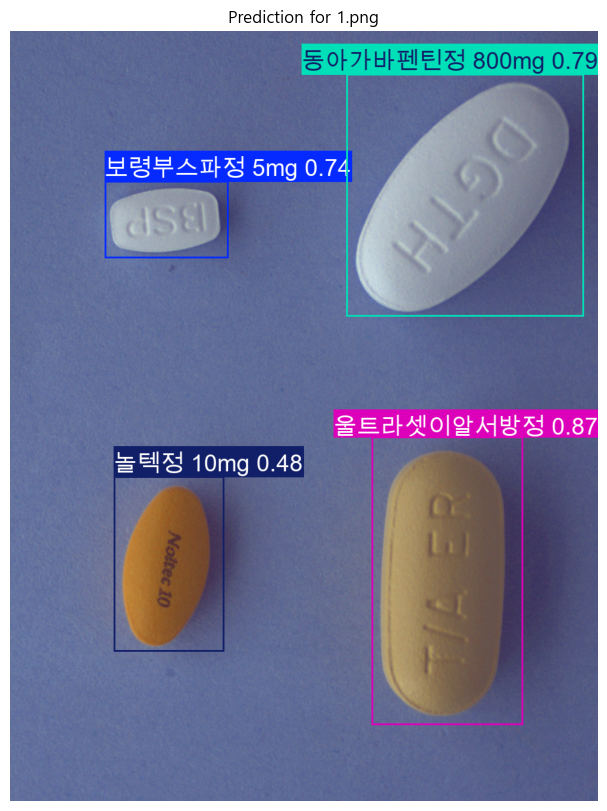

First image's detections:
  - Class: 울트라셋이알서방정 (YOLO ID: 51), Conf: 0.87, Bbox (norm xywh): [0.7434092164039612, 0.7140496373176575, 0.25705668330192566, 0.37425023317337036]
  - Class: 동아가바펜틴정 800mg (YOLO ID: 23), Conf: 0.79, Bbox (norm xywh): [0.7742140293121338, 0.21324267983436584, 0.40303486585617065, 0.314884752035141]
  - Class: 보령부스파정 5mg (YOLO ID: 0), Conf: 0.74, Bbox (norm xywh): [0.2666212320327759, 0.24521814286708832, 0.21016916632652283, 0.09993749111890793]
  - Class: 놀텍정 10mg (YOLO ID: 44), Conf: 0.48, Bbox (norm xywh): [0.270698219537735, 0.6921781301498413, 0.18751850724220276, 0.2275843620300293]


In [28]:
# 추론 결과 시각화 예시
# inference_results는 Results 객체
if inference_results:
    print("Displaying first inference result (if available)...")
    first_result = inference_results[0]
    im_bgr = first_result.plot()  # BGR 이미지 (OpenCV 형식)
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)  # RGB로 변환 (matplotlib용)

    plt.figure(figsize=(10, 10))
    plt.imshow(im_rgb)
    plt.title(f"Prediction for {Path(first_result.path).name}")
    plt.axis("off")
    plt.show()

    # 바운딩 박스 정보 출력 예시
    print("First image's detections:")
    for box_data in first_result.boxes:
        cls = int(box_data.cls)
        conf = float(box_data.conf)
        xywh_norm = box_data.xywhn[0].tolist()  # 정규화된 xywh

        # YOLO 클래스 ID를 실제 카테고리 이름으로 변환
        class_name = yolo_idx_to_name_map.get(cls, f"Unknown_{cls}")
        print(
            f"  - Class: {class_name} (YOLO ID: {cls}), Conf: {conf:.2f}, Bbox (norm xywh): {xywh_norm}"
        )

In [29]:
# ====================================================================
# 임시 파일 삭제
# ====================================================================
shutil.rmtree(YOLO_LABELS_TEMP)
print(f"Removed temporary YOLO label directory: {YOLO_LABELS_TEMP}")

Removed temporary YOLO label directory: \Users\user\myproject\AI03-Project-1\data\processed\yolo_labels_temp
